In [1]:
import numpy as np
import matplotlib.pyplot as plt
import torch

In [4]:
def get_dtv_ub(a, b, c):
    def dtv_ub_func(t):
        return a*np.exp(-t) + (b+c)*np.sqrt(t)
    return dtv_ub_func

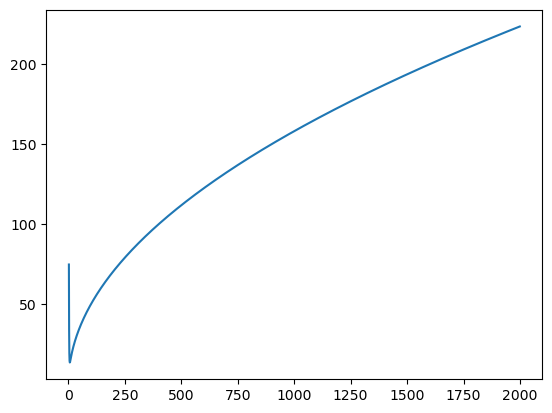

In [21]:
a = 500
b = 2
c = 3
dtv_ub = get_dtv_ub(a, b, c)

plt.figure()
plt.plot(np.arange(2, 2000), dtv_ub(np.arange(2, 2000)))
plt.show()

In [16]:
dtv_ub(np.arange(2, 2000))

array([6.8233327 , 2.55863545, 0.99578194, ..., 1.78751224, 1.78795973,
       1.78840711])

In [ ]:
#code up a simple perceptron model
#examine how mode collapse changes with T
#can you calculate score_true analytically?

In [ ]:
class noise_model(nn.Module):
    def __init__(self, hidden=64, dr, dim=64, time_embed_dim=256):
        super(model_o3_err, self).__init__()
        #time_embedding common to all blocks
        self.time_mlp = nn.Sequential(
            SinusoidalPositionEmbeddings(dim),
            nn.Linear(dim, time_embed_dim),
            nn.GELU(),
            nn.Linear(time_embed_dim, time_embed_dim),
        )

        # input: 1 ---------------> output: hidden (64)
        self.C01 = nn.Linear(2, hidden)
        self.C02 = nn.Linear(hidden, hidden)
        self.time_dep0 = nn.Sequential(nn.SiLU(), nn.Linear(time_embed_dim, hidden)) #TODO: ADD einsum here to go from b c to b c 1 1 
        self.B01 = nn.BatchNorm1d(hidden)

        # input: hidden ---------------> output: width2 (32)
        width2 = int(hidden/2)
        self.C11 = nn.Linear(hidden, width2)
        self.C12 = nn.Linear(width2, width2)
        self.time_dep1 = nn.Sequential(nn.SiLU(), nn.Linear(time_embed_dim, width2)) #TODO: ADD einsum here to go from b c to b c 1 1 
        self.B11 = nn.BatchNorm1d(width2)
        
        
        # input: width2 ---------------> output: width3 (16)
        width3 = int(hidden/4)
        self.C21 = nn.Linear(hidden, width3)
        self.C22 = nn.Linear(width3, width3)
        self.time_dep2 = nn.Sequential(nn.SiLU(), nn.Linear(time_embed_dim, width3)) #TODO: ADD einsum here to go from b c to b c 1 1 
        self.B21 = nn.BatchNorm1d(width3)
        self.C23 = nn.Linear(width3, width3)
        
        self.final01 = nn.Linear(width3, 2)
        
        
    def forward(self, inputdata, time):
        time_embedded = self.time_mlp(time)
        x = self.Tanh(self.C01(inputdata))
        x = self.Tanh(self.B01(self.C02(x)))
        x += self.time_dep0(time_embedded)

        x = self.Tanh(self.C11(x))
        x = self.Tanh(self.B11(self.C12(x)))
        x += self.time_dep1(time_embedded)

        x = self.Tanh(self.C21(x))
        x = self.Tanh(self.B21(self.C22(x)))
        x += self.time_dep2(time_embedded)
        x = self.Tanh(self.C23(x))
        
        out = self.final01(x)
        return out

In [5]:
###
import torch
import hf_diffusion as hfd
noise_mod = hfd.noise_model()

sdict = torch.load('results/samples_exps/Run_12-4_0-56/checkpoint_12000.pt')
sdict.keys()

noise_mod.load_state_dict(sdict['model_state_dict'])

diff = hfd.Diffusion(sdict['betas'])

In [17]:
samps = diff.sample(noise_mod, 2, batch_size=1000, return_all_timesteps=False)

sample device cpu


sampling loop time step: 100%|██████████| 100/100 [00:00<00:00, 222.39it/s]


In [18]:
samps.shape

(1000, 2)

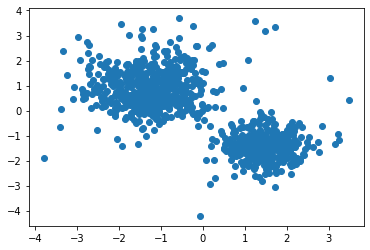

In [19]:
plt.figure()
plt.scatter(samps[:, 0], samps[:, 1])
plt.show()

### Testing Functions to Compute Terms

In [2]:
import torch.distributions as dbn
from scipy import integrate
import sys
import hf_diffusion as hfd
import importlib
sys.path.append('hf_diffusion')
import datasets
import matplotlib.pyplot as plt

In [3]:
pdbn = dbn.MultivariateNormal(loc = torch.ones(2), scale_tril = torch.eye(2))

In [4]:
pdbn.precision_matrix

tensor([[1., -0.],
        [-0., 1.]])

In [5]:
#https://statproofbook.github.io/P/mvn-kl.html

def kldiv_Gaussians(p, q):
    #torch dbns for MVNormal
    det_q = torch.det(q.covariance_matrix)
    det_p = torch.det(p.covariance_matrix)
    term3 = np.log(det_q) - np.log(det_p)
    
    mdiff = (q.mean - p.mean).reshape((-1, 1))
    invqcov = torch.linalg.inv(q.covariance_matrix)
    term1 = (mdiff.T@invqcov@mdiff)[0, 0]
    
    term2 = (invqcov@p.covariance_matrix).trace()
    print(term1.shape, term2.shape, term3.shape)
    return 0.5*(term1 + term2 + term3 - len(q.mean)).numpy()

In [6]:
def get_overlap_integral(g1, g2):
    #computes z_a, alpha
    minbounds = torch.min(torch.stack([g1.mean - 10*torch.diag(g1.covariance_matrix), g2.mean - 10*torch.diag(g2.covariance_matrix)]), dim=0)[0]
    maxbounds = torch.max(torch.stack([g1.mean + 10*torch.diag(g1.covariance_matrix), g2.mean + 10*torch.diag(g2.covariance_matrix)]), dim=0)[0]
    print('Integration bounds', minbounds, maxbounds)
    def prod_gaussians(y, x):
        input_t = torch.from_numpy(np.array([x, y]))
        return np.exp(g1.log_prob(input_t) + g2.log_prob(input_t))
    int_out = integrate.dblquad(prod_gaussians, minbounds[0], maxbounds[0], minbounds[1], maxbounds[1])
    print('tol', int_out[1])
    return int_out[0]

In [7]:
def kldiv_MOGS_UpperBound(mix1, mix2):
    #implements https://ieeexplore-ieee-org.ezp-prod1.hul.harvard.edu/stamp/stamp.jsp?tp=&arnumber=6289001
    ub= 0
    for ic1 in range(mix1.Ncomp):
        num = 0
        for ic11 in range(mix1.Ncomp):
            numterm = mix1.weights[ic11]*get_overlap_integral(mix1.dbns[ic1], mix1.dbns[ic11])
            num += numterm
        denom = 0
        for ic2 in range(mix2.Ncomp):
            denom_term = mix2.weights[ic2]*np.exp(-kldiv_Gaussians(mix1.dbns[ic1], mix2.dbns[ic2]))
            denom += denom_term
        
        ubterm = mix1.weights[ic1]*(np.log(num) - np.log(denom) + mix1.dbns[ic1].entropy())
        print('Comp{}: num={:.3f} denom={:.3f} ub={:.3f}'.format(ic1, numterm, denom_term, ubterm))
        ub += ubterm
    return ub

In [8]:
def get_term1_for_truedbn(truemix, T):
    normal = dbn.MultivariateNormal(torch.zeros(truemix.Ncomp), torch.eye(truemix.Ncomp))
    mix2 = datasets.GaussianMixtureDataset([1.0], [normal.mean.numpy()], [normal.scale_tril.numpy()])
    kldiv = kldiv_MOGS_UpperBound(truemix, mix2)
    return np.sqrt(kldiv)*np.exp(-T)

In [9]:
def get_term2_for_truedbn(L, d, h, m2, T):
    return L*(np.sqrt(d*h) + m2*h)

In [10]:
def get_term3_for_truedbn(eps_score, T):
    return eps_score*np.sqrt(T)

In [11]:
weights = np.array([0.7, 0.3], dtype=np.float32)
means = [np.array([-1, 2], dtype=np.float32), np.array([2, -1], dtype=np.float32)]
covs = [np.diag(np.array([0.8, 0.8], dtype=np.float32)), np.diag(np.array([0.6, 0.6], dtype=np.float32))]
print(len(weights), len(means), len(covs))
traindata = datasets.GaussianMixtureDataset(weights, means, covs)

2 2 2
2 2 2


In [12]:
traindata.dbns[0].mean, traindata.dbns[0].covariance_matrix, traindata.dbns[1].mean, traindata.dbns[1].covariance_matrix

(tensor([-1.,  2.]),
 tensor([[0.6400, 0.0000],
         [0.0000, 0.6400]]),
 tensor([ 2., -1.]),
 tensor([[0.3600, 0.0000],
         [0.0000, 0.3600]]))

In [13]:
kldiv_Gaussians(traindata.dbns[0], traindata.dbns[1])

torch.Size([]) torch.Size([]) torch.Size([])


25.20241355895996

In [14]:
ov = get_overlap_integral(traindata.dbns[0], traindata.dbns[1])

Integration bounds tensor([-7.4000, -4.6000]) tensor([5.6000, 8.4000])
tol 1.4577349601842132e-08


In [15]:
ov

1.964128558168901e-05

In [16]:
normal = dbn.MultivariateNormal(torch.zeros(2), torch.eye(2))
mix2 = datasets.GaussianMixtureDataset([1.0], [normal.mean.numpy()], [normal.scale_tril.numpy()])
ub_kldiv = kldiv_MOGS_UpperBound(traindata, mix2)

1 1 1
Integration bounds tensor([-7.4000, -4.4000]) tensor([5.4000, 8.4000])
tol 9.882205801468884e-09
Integration bounds tensor([-7.4000, -4.6000]) tensor([5.6000, 8.4000])
tol 1.4577349601842132e-08
torch.Size([]) torch.Size([]) torch.Size([])
Comp0: num=0.000 denom=0.075 ub=1.776
Integration bounds tensor([-7.4000, -4.6000]) tensor([5.6000, 8.4000])
tol 1.4577349601842132e-08
Integration bounds tensor([-1.6000, -4.6000]) tensor([5.6000, 2.6000])
tol 1.4350803976339059e-08
torch.Size([]) torch.Size([]) torch.Size([])
Comp1: num=0.066 denom=0.056 ub=0.595


In [17]:
ub_kldiv

tensor(2.3710)

In [18]:
diff = hfd.Diffusion(betas = torch.tensor(np.linspace(0.0001, 0.02, 100)))

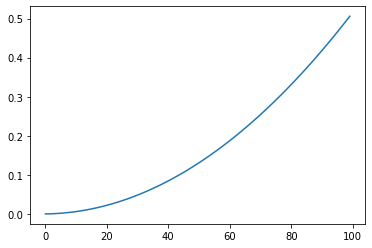

In [19]:
plt.figure()
plt.plot(np.arange(100), -np.log(diff.sqrt_alphas_cumprod))
plt.show()

In [20]:
def get_paper_T_for_diffusion(diff):
    return -np.log(diff.sqrt_alphas_cumprod[-1])

In [21]:
term1 = get_term1_for_truedbn(traindata, get_paper_T_for_diffusion(diff))

1 1 1
Integration bounds tensor([-7.4000, -4.4000]) tensor([5.4000, 8.4000])
tol 9.882205801468884e-09
Integration bounds tensor([-7.4000, -4.6000]) tensor([5.6000, 8.4000])
tol 1.4577349601842132e-08
torch.Size([]) torch.Size([]) torch.Size([])
Comp0: num=0.000 denom=0.075 ub=1.776
Integration bounds tensor([-7.4000, -4.6000]) tensor([5.6000, 8.4000])
tol 1.4577349601842132e-08
Integration bounds tensor([-1.6000, -4.6000]) tensor([5.6000, 2.6000])
tol 1.4350803976339059e-08
torch.Size([]) torch.Size([]) torch.Size([])
Comp1: num=0.066 denom=0.056 ub=0.595


In [22]:
term1

tensor(0.9284, dtype=torch.float64)

In [123]:
nontterm1

tensor(1.5398, dtype=torch.float64)

In [24]:
nontterm1 = term1/np.exp(-get_paper_T_for_diffusion(diff))

In [26]:
0.3/nontterm1

tensor(0.1948, dtype=torch.float64)

In [27]:
def get_h_for_beta(betas):
    return np.log(1-betas)/(-2)

In [28]:
hvals = get_h_for_beta(diff.betas)

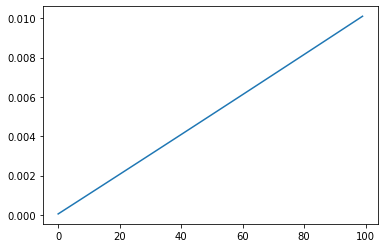

In [29]:
plt.figure()
plt.plot(np.arange(len(diff.betas)), hvals)
plt.show()

In [30]:
hvals.min(), hvals.max()

(tensor(5.0003e-05, dtype=torch.float64), tensor(0.0101, dtype=torch.float64))

In [31]:
m2 = [traindata.weights[i]*torch.diag(traindata.dbns[i].covariance_matrix) for i in range(traindata.Ncomp)]

In [34]:
torch.sum(torch.stack(m2), dim=0)

tensor([0.5560, 0.5560])

In [35]:
test = torch.zeros(2)

### Term2 : Partial Derivatives

In [52]:
importlib.reload(datasets)

weights = np.array([0.7, 0.3], dtype=np.float32)
means = [np.array([-1, 2], dtype=np.float32), np.array([2, -1], dtype=np.float32)]
covs = [np.diag(np.array([0.8, 0.8], dtype=np.float32)), np.diag(np.array([0.6, 0.6], dtype=np.float32))]
print(len(weights), len(means), len(covs))
traindata = datasets.GaussianMixtureDataset(weights, means, covs)
score = traindata.get_score(test)

2 2 2
2 2 2


In [53]:
score

array([[-1.3117635],
       [ 2.9170723]], dtype=float32)

In [54]:
score = traindata.get_score(traindata.dbns[0].mean+traindata.dbns[0].scale_tril@torch.randn(2))

In [55]:
score

array([[0.23827739],
       [1.1462637 ]], dtype=float32)

In [56]:
traindata.get_partial_derivative_dbns(test, 0, 0), traindata.get_partial_derivative_gmm(test, 0)

(tensor(-0.0078), tensor(-0.0048))

In [57]:
traindata.dbns[0].precision_matrix

tensor([[1.5625, -0.0000],
        [-0.0000, 1.5625]])

In [58]:
traindata.get_partial_derivative_score(test, 1)

tensor(0.0078) tensor(-0.0489) tensor(0.0456)
tensor(0.0012) tensor(-0.0033) tensor(-0.0035)


tensor(-0.4212)

In [59]:
traindata.get_partial_derivative_score(test, 1)

tensor(0.0078) tensor(-0.0489) tensor(0.0456)
tensor(0.0012) tensor(-0.0033) tensor(-0.0035)


tensor(-0.4212)

In [60]:
g1 = traindata.dbns[0]
g2 = traindata.dbns[1]
minbounds = torch.min(torch.stack([g1.mean - 10*torch.diag(g1.covariance_matrix), g2.mean - 10*torch.diag(g2.covariance_matrix)]), dim=0)[0].numpy()
maxbounds = torch.max(torch.stack([g1.mean + 10*torch.diag(g1.covariance_matrix), g2.mean + 10*torch.diag(g2.covariance_matrix)]), dim=0)[0].numpy()
xgrid = np.meshgrid(np.linspace(minbounds[0], maxbounds[0], 20), np.linspace(minbounds[1], maxbounds[1], 20))

In [61]:
testpts = torch.from_numpy(np.vstack([xgrid[0].flatten(), xgrid[1].flatten()]).T.astype(np.float32))

In [62]:
testpts.shape

torch.Size([400, 2])

In [63]:
score_pd0 = [traindata.get_partial_derivative_score(testpts[t, :], 0) for t in range(len(testpts))]

tensor(1.5625) tensor(-100.0000) tensor(3.6621e-28)
tensor(2.7778) tensor(-681.7902) tensor(9.5621e-28)
tensor(1.5625) tensor(-79.7614) tensor(1.8975e-25)
tensor(2.7778) tensor(-586.1495) tensor(5.1438e-25)
tensor(1.5625) tensor(-61.8086) tensor(4.5962e-23)
tensor(2.7778) tensor(-497.7336) tensor(1.3043e-22)
tensor(1.5625) tensor(-46.1416) tensor(5.1612e-21)
tensor(2.7778) tensor(-416.5419) tensor(1.5507e-20)
tensor(1.5625) tensor(-32.7606) tensor(2.6523e-19)
tensor(2.7778) tensor(-342.5746) tensor(8.5769e-19)
tensor(1.5625) tensor(-21.6654) tensor(6.1093e-18)
tensor(2.7778) tensor(-275.8319) tensor(2.1799e-17)
tensor(1.5625) tensor(-12.8560) tensor(6.0758e-17)
tensor(2.7778) tensor(-216.3135) tensor(2.4923e-16)
tensor(1.5625) tensor(-6.3325) tensor(2.4138e-16)
tensor(2.7778) tensor(-164.0197) tensor(1.2284e-15)
tensor(1.5625) tensor(-2.0949) tensor(3.2590e-16)
tensor(2.7778) tensor(-118.9503) tensor(2.4558e-15)
tensor(1.5625) tensor(-0.1431) tensor(3.1832e-15)
tensor(2.7778) tensor(-8

tensor(2.7778) tensor(-65.6005) tensor(2.3012e-05)
tensor(1.5625) tensor(-106.3477) tensor(7.4012e-08)
tensor(2.7778) tensor(-100.0000) tensor(7.1769e-08)
tensor(1.5625) tensor(-100.0000) tensor(8.2133e-17)
tensor(2.7778) tensor(-681.7902) tensor(2.1446e-16)
tensor(1.5625) tensor(-79.7614) tensor(4.2556e-14)
tensor(2.7778) tensor(-586.1495) tensor(1.1536e-13)
tensor(1.5625) tensor(-61.8086) tensor(1.0309e-11)
tensor(2.7778) tensor(-497.7336) tensor(2.9253e-11)
tensor(1.5625) tensor(-46.1416) tensor(1.1576e-09)
tensor(2.7778) tensor(-416.5419) tensor(3.4780e-09)
tensor(1.5625) tensor(-32.7606) tensor(5.9487e-08)
tensor(2.7778) tensor(-342.5746) tensor(1.9236e-07)
tensor(1.5625) tensor(-21.6654) tensor(1.3702e-06)
tensor(2.7778) tensor(-275.8319) tensor(4.8891e-06)
tensor(1.5625) tensor(-12.8560) tensor(1.3627e-05)
tensor(2.7778) tensor(-216.3135) tensor(5.5897e-05)
tensor(1.5625) tensor(-6.3325) tensor(5.4134e-05)
tensor(2.7778) tensor(-164.0197) tensor(0.0003)
tensor(7.4052e-05) tensor

tensor(3.9353e-07) tensor(-2.7907e-07) tensor(-7.7504e-07)
tensor(0.0001) tensor(-0.0022) tensor(0.0022)
tensor(5.3660e-07) tensor(-4.7731e-08) tensor(4.7656e-07)
tensor(1.5625) tensor(-36.4355) tensor(5.2645e-05)
tensor(2.7778) tensor(-5.7488) tensor(2.0911e-05)
tensor(1.5625) tensor(-50.4848) tensor(8.7549e-07)
tensor(2.7778) tensor(-18.4749) tensor(5.2962e-07)
tensor(1.5625) tensor(-66.8199) tensor(8.7911e-09)
tensor(2.7778) tensor(-38.4255) tensor(6.6665e-09)
tensor(1.5625) tensor(-85.4408) tensor(5.2753e-11)
tensor(2.7778) tensor(-65.6005) tensor(4.6224e-11)
tensor(1.5625) tensor(-106.3477) tensor(1.2454e-13)
tensor(2.7778) tensor(-100.0000) tensor(1.2076e-13)
tensor(1.5625) tensor(-100.0000) tensor(1.1277e-13)
tensor(2.7778) tensor(-681.7902) tensor(2.9444e-13)
tensor(1.5625) tensor(-79.7614) tensor(5.8428e-11)
tensor(2.7778) tensor(-586.1495) tensor(1.5839e-10)
tensor(1.5625) tensor(-61.8086) tensor(1.4153e-08)
tensor(2.7778) tensor(-497.7336) tensor(4.0163e-08)
tensor(1.5625) t

tensor(1.5625) tensor(-15.1946) tensor(7.9117e-09)
tensor(2.7778) tensor(-1.9698) tensor(-2.8487e-09)
tensor(1.5625) tensor(-24.6721) tensor(6.1895e-10)
tensor(2.7778) tensor(-0.2471) tensor(6.1940e-11)
tensor(1.5625) tensor(-36.4355) tensor(2.1192e-11)
tensor(2.7778) tensor(-5.7488) tensor(8.4177e-12)
tensor(1.5625) tensor(-50.4848) tensor(3.2758e-13)
tensor(2.7778) tensor(-18.4749) tensor(1.9817e-13)
tensor(1.5625) tensor(-66.8199) tensor(2.3276e-15)
tensor(2.7778) tensor(-38.4255) tensor(1.7651e-15)
tensor(1.5625) tensor(-85.4408) tensor(7.6883e-18)
tensor(2.7778) tensor(-65.6005) tensor(6.7368e-18)
tensor(1.5625) tensor(-106.3477) tensor(1.1896e-20)
tensor(2.7778) tensor(-100.0000) tensor(1.1535e-20)
tensor(1.5625) tensor(-100.0000) tensor(5.6691e-22)
tensor(2.7778) tensor(-681.7902) tensor(1.4803e-21)
tensor(1.5625) tensor(-79.7614) tensor(2.9374e-19)
tensor(2.7778) tensor(-586.1495) tensor(7.9628e-19)
tensor(1.5625) tensor(-61.8086) tensor(7.1152e-17)
tensor(2.7778) tensor(-497.7

In [64]:
score_pd1 = [traindata.get_partial_derivative_score(testpts[t, :], 1) for t in range(len(testpts))]

tensor(1.5625) tensor(-106.3477) tensor(3.8945e-28)
tensor(2.7778) tensor(-100.0000) tensor(3.7765e-28)
tensor(1.5625) tensor(-106.3477) tensor(2.5299e-25)
tensor(2.7778) tensor(-100.0000) tensor(2.4533e-25)
tensor(1.5625) tensor(-106.3477) tensor(7.9083e-23)
tensor(2.7778) tensor(-100.0000) tensor(7.6686e-23)
tensor(1.5625) tensor(-106.3477) tensor(1.1896e-20)
tensor(2.7778) tensor(-100.0000) tensor(1.1535e-20)
tensor(1.5625) tensor(-106.3477) tensor(8.6101e-19)
tensor(2.7778) tensor(-100.0000) tensor(8.3492e-19)
tensor(1.5625) tensor(-106.3477) tensor(2.9989e-17)
tensor(2.7778) tensor(-100.0000) tensor(2.9080e-17)
tensor(1.5625) tensor(-106.3477) tensor(5.0261e-16)
tensor(2.7778) tensor(-100.0000) tensor(4.8738e-16)
tensor(1.5625) tensor(-106.3477) tensor(4.0535e-15)
tensor(2.7778) tensor(-100.0000) tensor(3.9307e-15)
tensor(1.5625) tensor(-106.3477) tensor(1.5835e-14)
tensor(2.7778) tensor(-100.0000) tensor(1.5356e-14)
tensor(1.5625) tensor(-106.3477) tensor(1.2454e-13)
tensor(2.777

tensor(1.5625) tensor(-36.4355) tensor(5.0769e-06)
tensor(2.7778) tensor(-5.7488) tensor(2.0166e-06)
tensor(1.5625) tensor(-36.4355) tensor(1.0387e-08)
tensor(2.7778) tensor(-5.7488) tensor(4.1258e-09)
tensor(1.5625) tensor(-24.6721) tensor(2.0264e-17)
tensor(2.7778) tensor(-0.2471) tensor(2.0279e-18)
tensor(1.5625) tensor(-24.6721) tensor(1.3164e-14)
tensor(2.7778) tensor(-0.2471) tensor(1.3173e-15)
tensor(1.5625) tensor(-24.6721) tensor(4.1148e-12)
tensor(2.7778) tensor(-0.2471) tensor(4.1179e-13)
tensor(1.5625) tensor(-24.6721) tensor(6.1895e-10)
tensor(2.7778) tensor(-0.2471) tensor(6.1940e-11)
tensor(1.5625) tensor(-24.6721) tensor(4.4800e-08)
tensor(2.7778) tensor(-0.2471) tensor(4.4833e-09)
tensor(1.5625) tensor(-24.6721) tensor(1.5604e-06)
tensor(2.7778) tensor(-0.2471) tensor(1.5615e-07)
tensor(1.5625) tensor(-24.6721) tensor(2.6152e-05)
tensor(2.7778) tensor(-0.2471) tensor(2.6171e-06)
tensor(1.5625) tensor(-24.6721) tensor(0.0002)
tensor(2.7778) tensor(-0.2471) tensor(2.1107

tensor(0.0287) tensor(-0.0026) tensor(0.0026)
tensor(7.8623e-08) tensor(-2.2956e-06) tensor(9.6430e-08)
tensor(0.0029) tensor(-0.0003) tensor(0.0003)
tensor(3.9353e-07) tensor(-1.1490e-05) tensor(4.8301e-07)
tensor(0.0001) tensor(-1.2665e-05) tensor(1.2935e-05)
tensor(5.3660e-07) tensor(-1.5668e-05) tensor(6.7215e-07)
tensor(1.5625) tensor(-0.1431) tensor(2.7888e-07)
tensor(2.7778) tensor(-81.1053) tensor(6.6393e-06)
tensor(1.5625) tensor(-0.1431) tensor(9.7147e-09)
tensor(2.7778) tensor(-81.1053) tensor(2.3128e-07)
tensor(1.5625) tensor(-0.1431) tensor(2.1691e-10)
tensor(2.7778) tensor(-81.1053) tensor(5.1639e-09)
tensor(1.5625) tensor(-0.1431) tensor(1.5684e-12)
tensor(2.7778) tensor(-81.1053) tensor(3.7338e-11)
tensor(1.5625) tensor(-0.1431) tensor(3.1832e-15)
tensor(2.7778) tensor(-81.1053) tensor(7.5782e-14)
tensor(1.5625) tensor(-2.0949) tensor(2.3623e-15)
tensor(2.7778) tensor(-118.9503) tensor(1.7801e-14)
tensor(1.5625) tensor(-2.0949) tensor(1.5346e-12)
tensor(2.7778) tensor(-

tensor(2.7778) tensor(-416.5419) tensor(8.0131e-06)
tensor(1.5625) tensor(-46.1416) tensor(1.1532e-06)
tensor(2.7778) tensor(-416.5419) tensor(3.4649e-06)
tensor(1.5625) tensor(-46.1416) tensor(2.3995e-07)
tensor(2.7778) tensor(-416.5419) tensor(7.2096e-07)
tensor(1.5625) tensor(-46.1416) tensor(2.4026e-08)
tensor(2.7778) tensor(-416.5419) tensor(7.2187e-08)
tensor(1.5625) tensor(-46.1416) tensor(1.1576e-09)
tensor(2.7778) tensor(-416.5419) tensor(3.4780e-09)
tensor(1.5625) tensor(-46.1416) tensor(2.6837e-11)
tensor(2.7778) tensor(-416.5419) tensor(8.0634e-11)
tensor(1.5625) tensor(-46.1416) tensor(2.9940e-13)
tensor(2.7778) tensor(-416.5419) tensor(8.9956e-13)
tensor(1.5625) tensor(-46.1416) tensor(1.6073e-15)
tensor(2.7778) tensor(-416.5419) tensor(4.8292e-15)
tensor(1.5625) tensor(-46.1416) tensor(4.1520e-18)
tensor(2.7778) tensor(-416.5419) tensor(1.2475e-17)
tensor(1.5625) tensor(-46.1416) tensor(5.1612e-21)
tensor(2.7778) tensor(-416.5419) tensor(1.5507e-20)
tensor(1.5625) tensor

In [71]:
score_pds = torch.stack([torch.stack(score_pd0), torch.stack(score_pd1)]).T

In [72]:
score_pds.shape

torch.Size([400, 2])

In [73]:
score_pds_sum = np.sqrt(score_pds[:, 0]**2 + score_pds[:, 1]**2)

In [88]:
plt.rcParams.update({'font.family':'DejaVu Sans', 'font.size': 16})

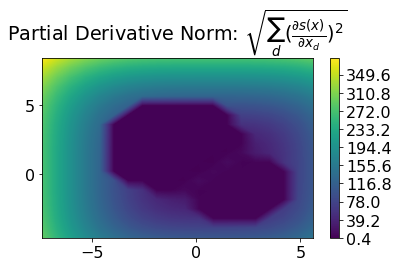

In [108]:
plt.figure()
c = plt.contourf(*[xg[:, :] for xg in xgrid], score_pds_sum.reshape((20, 20)), levels=1000)
plt.colorbar(c)
plt.title(r'Partial Derivative Norm: $\sqrt{\sum_d (\frac{\partial s(x)}{\partial x_d})^2}$')
plt.tight_layout()
plt.savefig('plots/Baseline/score_pd.png')
plt.show()

In [117]:
truedraws =np.stack([traindata[i] for i in range(10000)])

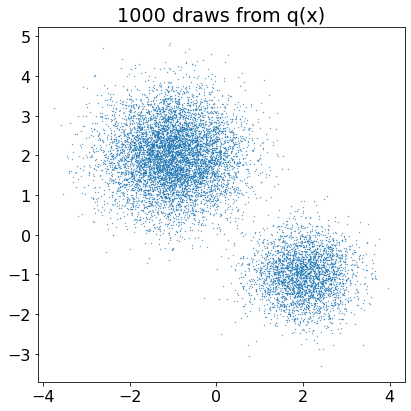

In [121]:
plt.figure(figsize=(6, 6))
plt.scatter(truedraws[:, 0], truedraws[:, 1], s=0.1)
plt.title('1000 draws from q(x)')
plt.tight_layout()
plt.savefig('plots/Baseline/truesamples.png')
plt.show()

In [99]:
scoretestpts = np.stack([traindata.get_score(testpts[pi, :]) for pi in range(testpts.shape[0])])

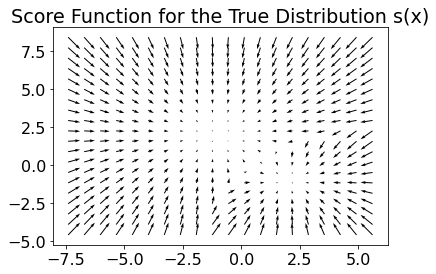

In [106]:
plt.figure()
plt.tight_layout()
plt.quiver(xgrid[0], xgrid[1], scoretestpts[:, 0], scoretestpts[:, 1])
plt.title(r'Score Function for the True Distribution s(x)')
plt.savefig('plots/Baseline/score.png')
plt.show()

In [103]:
score_pds_sum.max()

tensor(385.5288)

In [87]:
def compute_lipschitz_for_point(test, mix):
    pd0 = mix.get_partial_derivative_score(test, 0)
    pd1= mix.get_partial_derivative_score(test, 1)
    return np.sqrt(pd0**2+pd1**2)

In [90]:
g1 = traindata.dbns[0]
g2 = traindata.dbns[1]
minbounds = torch.min(torch.stack([g1.mean - 10*torch.diag(g1.covariance_matrix), g2.mean - 10*torch.diag(g2.covariance_matrix)]), dim=0)[0].numpy()
maxbounds = torch.max(torch.stack([g1.mean + 10*torch.diag(g1.covariance_matrix), g2.mean + 10*torch.diag(g2.covariance_matrix)]), dim=0)[0].numpy()

In [92]:
xgrid = np.meshgrid(np.linspace(minbounds[0], maxbounds[0], 20), np.linspace(minbounds[1], maxbounds[1], 20))

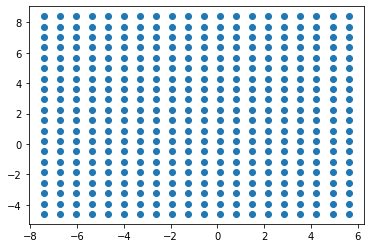

In [112]:
plt.figure()
plt.scatter(xgrid[0].flatten(), xgrid[1].flatten())
plt.show()

In [99]:
import functorch

In [101]:
from functorch import vmap
from functools import partial

In [122]:
testpts = torch.from_numpy(np.vstack([xgrid[0].flatten(), xgrid[1].flatten()]).T.astype(np.float32))

In [124]:
testpts.shape

torch.Size([400, 2])

In [125]:
lipsconst = [compute_lipschitz_for_point(testpts[pi, :], traindata) for pi in range(testpts.shape[0])]

tensor(-8.1743e-30) tensor(5.2316e-28) tensor(-142.8572)
tensor(-0.) tensor(0.) tensor(-373.0159)
tensor(-8.1743e-30) tensor(5.5636e-28) tensor(-151.9252)
tensor(-0.) tensor(0.) tensor(-147.3214)
tensor(-5.3101e-27) tensor(2.7107e-25) tensor(-113.9448)
tensor(-0.) tensor(0.) tensor(-308.8890)
tensor(-5.3101e-27) tensor(3.6142e-25) tensor(-151.9252)
tensor(-0.) tensor(0.) tensor(-147.3214)
tensor(-1.6599e-24) tensor(6.5661e-23) tensor(-88.2980)
tensor(-0.) tensor(0.) tensor(-250.5675)
tensor(-1.6599e-24) tensor(1.1298e-22) tensor(-151.9252)
tensor(-0.) tensor(0.) tensor(-147.3214)
tensor(-2.4968e-22) tensor(7.3731e-21) tensor(-65.9166)
tensor(-5.1237e-41) tensor(7.6832e-39) tensor(-198.0513)
tensor(-2.4968e-22) tensor(1.6994e-20) tensor(-151.9252)
tensor(-5.1237e-41) tensor(1.8445e-39) tensor(-147.3215)
tensor(-1.8072e-20) tensor(3.7891e-19) tensor(-46.8008)
tensor(-3.1033e-35) tensor(3.8272e-33) tensor(-151.3405)
tensor(-1.8072e-20) tensor(1.2300e-18) tensor(-151.9252)
tensor(-3.1033e-

tensor(-8.6259e-28) tensor(4.7168e-26) tensor(-249.5544)
tensor(-1.3923e-13) tensor(3.2880e-12) tensor(-218.6684)
tensor(-2.5456e-24) tensor(1.6292e-22) tensor(-142.8572)
tensor(-0.) tensor(0.) tensor(-373.0159)
tensor(-2.5456e-24) tensor(1.0886e-22) tensor(-95.4570)
tensor(-0.) tensor(0.) tensor(-72.3877)
tensor(-1.6537e-21) tensor(8.4414e-20) tensor(-113.9448)
tensor(-0.) tensor(0.) tensor(-308.8890)
tensor(-1.6537e-21) tensor(7.0718e-20) tensor(-95.4570)
tensor(-0.) tensor(0.) tensor(-72.3877)
tensor(-5.1692e-19) tensor(2.0448e-17) tensor(-88.2980)
tensor(-1.4980e-42) tensor(2.6852e-40) tensor(-250.5675)
tensor(-5.1692e-19) tensor(2.2106e-17) tensor(-95.4570)
tensor(-1.4980e-42) tensor(2.0735e-41) tensor(-72.3877)
tensor(-7.7754e-17) tensor(2.2961e-15) tensor(-65.9166)
tensor(-3.3347e-36) tensor(5.0005e-34) tensor(-198.0513)
tensor(-7.7754e-17) tensor(3.3251e-15) tensor(-95.4570)
tensor(-3.3347e-36) tensor(4.6129e-35) tensor(-72.3877)
tensor(-5.6279e-15) tensor(1.1800e-13) tensor(-4

tensor(-9.3969e-11) tensor(2.1912e-09) tensor(-52.0508)
tensor(-7.2398e-28) tensor(1.4983e-27) tensor(-20.6753)
tensor(-3.2729e-09) tensor(4.5382e-08) tensor(-30.9505)
tensor(-1.1946e-22) tensor(1.1862e-20) tensor(-110.4351)
tensor(-3.2729e-09) tensor(7.6320e-08) tensor(-52.0507)
tensor(-1.1946e-22) tensor(2.4722e-22) tensor(-20.6753)
tensor(-5.4854e-08) tensor(4.5133e-07) tensor(-18.3657)
tensor(-5.3695e-18) tensor(4.1814e-16) tensor(-75.3350)
tensor(-5.4854e-08) tensor(1.2791e-06) tensor(-52.0507)
tensor(-5.3695e-18) tensor(1.1113e-17) tensor(-20.6753)
tensor(-4.4239e-07) tensor(1.7929e-06) tensor(-9.0464)
tensor(-6.5751e-14) tensor(3.8824e-12) tensor(-46.0403)
tensor(-4.4239e-07) tensor(1.0316e-05) tensor(-52.0508)
tensor(-6.5751e-14) tensor(1.3608e-13) tensor(-20.6753)
tensor(-1.7168e-06) tensor(2.3018e-06) tensor(-2.9942)
tensor(-2.1934e-10) tensor(9.3925e-09) tensor(-22.5624)
tensor(-1.7168e-06) tensor(4.0034e-05) tensor(-52.0506)
tensor(-2.1934e-10) tensor(4.5393e-10) tensor(-20

tensor(-9.7427e-05) tensor(6.9090e-05) tensor(7.6858)
tensor(-0.0011) tensor(0.0022) tensor(16.0891)
tensor(-0.0066) tensor(0.0641) tensor(-47.5822)
tensor(-0.0011) tensor(0.0108) tensor(1.7333)
tensor(-0.0066) tensor(0.0047) tensor(-0.6241)
tensor(-0.0002) tensor(0.0012) tensor(30.8201)
tensor(-0.1207) tensor(0.4745) tensor(-35.9966)
tensor(-0.0002) tensor(0.0023) tensor(17.9204)
tensor(-0.1207) tensor(0.0856) tensor(-6.4524)
tensor(-2.3235e-05) tensor(0.0002) tensor(18.2300)
tensor(-0.6043) tensor(0.4285) tensor(-6.5638)
tensor(-2.3235e-05) tensor(0.0002) tensor(18.2300)
tensor(-0.6043) tensor(0.4285) tensor(-6.5638)
tensor(-1.1195e-06) tensor(1.7677e-05) tensor(-8.2303)
tensor(-0.8240) tensor(0.0733) tensor(-0.8236)
tensor(-1.1195e-06) tensor(1.0886e-05) tensor(18.2362)
tensor(-0.8240) tensor(0.5843) tensor(-6.5660)
tensor(-2.5954e-08) tensor(6.0521e-07) tensor(-48.2424)
tensor(-0.3061) tensor(0.6334) tensor(-19.1626)
tensor(-2.5954e-08) tensor(2.5239e-07) tensor(18.2364)
tensor(-0.

tensor(-9.2848e-06) tensor(0.0001) tensor(-128.0832)
tensor(-7.4610e-11) tensor(1.4789e-10) tensor(30.5307)
tensor(-9.2848e-06) tensor(9.0545e-05) tensor(-90.2921)
tensor(-1.9274e-13) tensor(1.0539e-11) tensor(-249.5529)
tensor(-6.9730e-08) tensor(1.6468e-06) tensor(-218.6671)
tensor(-1.9274e-13) tensor(3.8204e-13) tensor(30.5314)
tensor(-6.9730e-08) tensor(6.8000e-07) tensor(-90.2944)
tensor(-2.3958e-16) tensor(1.6307e-14) tensor(-343.7487)
tensor(-1.4266e-10) tensor(5.1358e-09) tensor(-333.3321)
tensor(-2.3958e-16) tensor(4.7489e-16) tensor(30.5316)
tensor(-1.4266e-10) tensor(1.3912e-09) tensor(-90.2949)
tensor(-4.2239e-15) tensor(2.7033e-13) tensor(-142.8571)
tensor(-0.) tensor(0.) tensor(-373.0159)
tensor(-4.2239e-15) tensor(1.2900e-15) tensor(-0.6817)
tensor(-0.) tensor(0.) tensor(7.0118)
tensor(-2.7439e-12) tensor(1.4007e-10) tensor(-113.9448)
tensor(-0.) tensor(0.) tensor(-308.8890)
tensor(-2.7439e-12) tensor(8.3799e-13) tensor(-0.6817)
tensor(-0.) tensor(0.) tensor(7.0118)
tens

tensor(-5.1112e-10) tensor(6.8528e-10) tensor(-2.9927)
tensor(-0.) tensor(0.) tensor(-22.5509)
tensor(-7.6883e-08) tensor(2.2704e-06) tensor(-65.9166)
tensor(-1.6900e-42) tensor(2.5334e-40) tensor(-198.0513)
tensor(-7.6883e-08) tensor(1.0308e-07) tensor(-2.9927)
tensor(-1.6900e-42) tensor(7.2335e-41) tensor(-22.5509)
tensor(-5.5648e-06) tensor(0.0001) tensor(-46.8008)
tensor(-1.0243e-36) tensor(1.2632e-34) tensor(-151.3405)
tensor(-5.5648e-06) tensor(7.4609e-06) tensor(-2.9927)
tensor(-1.0243e-36) tensor(4.3862e-35) tensor(-22.5509)
tensor(-0.0002) tensor(0.0027) tensor(-30.9505)
tensor(-1.6901e-31) tensor(1.6782e-29) tensor(-110.4351)
tensor(-0.0002) tensor(0.0003) tensor(-2.9927)
tensor(-1.6901e-31) tensor(7.2373e-30) tensor(-22.5509)
tensor(-0.0032) tensor(0.0267) tensor(-18.3657)
tensor(-7.5969e-27) tensor(5.9159e-25) tensor(-75.3350)
tensor(-0.0032) tensor(0.0044) tensor(-2.9927)
tensor(-7.5969e-27) tensor(3.2531e-25) tensor(-22.5509)
tensor(-0.0262) tensor(0.1062) tensor(-9.0464)

tensor(-0.0032) tensor(0.0267) tensor(-18.3657)
tensor(-7.5968e-27) tensor(5.9159e-25) tensor(-75.3350)
tensor(-0.0061) tensor(0.0006) tensor(-0.2044)
tensor(-6.9038e-24) tensor(2.0158e-22) tensor(-4.8669)
tensor(-0.0061) tensor(0.0499) tensor(-18.3657)
tensor(-6.9038e-24) tensor(5.3762e-22) tensor(-75.3350)
tensor(-0.0055) tensor(0.0017) tensor(-0.6817)
tensor(-1.7092e-21) tensor(3.1063e-20) tensor(7.0118)
tensor(-0.0055) tensor(0.0449) tensor(-18.3657)
tensor(-1.7092e-21) tensor(1.3310e-19) tensor(-75.3350)
tensor(-0.0024) tensor(0.0047) tensor(-4.4245)
tensor(-1.1527e-19) tensor(1.1241e-18) tensor(13.0851)
tensor(-0.0024) tensor(0.0194) tensor(-18.3657)
tensor(-1.1527e-19) tensor(8.9767e-18) tensor(-75.3350)
tensor(-0.0005) tensor(0.0025) tensor(-11.4328)
tensor(-2.1179e-18) tensor(8.3238e-18) tensor(13.3530)
tensor(-0.0005) tensor(0.0040) tensor(-18.3657)
tensor(-2.1179e-18) tensor(1.6493e-16) tensor(-75.3350)
tensor(-4.9107e-05) tensor(0.0005) tensor(-21.7066)
tensor(-1.0601e-17) 

tensor(-7.2398e-28) tensor(1.4983e-27) tensor(-20.6753)
tensor(-9.3969e-11) tensor(1.9702e-09) tensor(-46.8008)
tensor(-7.2398e-28) tensor(8.9286e-26) tensor(-151.3405)
tensor(-1.0483e-12) tensor(3.3872e-11) tensor(-72.1211)
tensor(-7.3263e-29) tensor(4.8727e-28) tensor(-43.6288)
tensor(-1.0483e-12) tensor(2.1980e-11) tensor(-46.8008)
tensor(-7.3263e-29) tensor(9.0353e-27) tensor(-151.3405)
tensor(-5.6279e-15) tensor(2.4067e-13) tensor(-95.4570)
tensor(-2.0197e-30) tensor(2.7939e-29) tensor(-72.3877)
tensor(-5.6279e-15) tensor(1.1800e-13) tensor(-46.8008)
tensor(-2.0197e-30) tensor(2.4908e-28) tensor(-151.3405)
tensor(-1.4538e-17) tensor(7.9498e-16) tensor(-122.0583)
tensor(-1.5168e-32) tensor(3.5822e-31) tensor(-106.9519)
tensor(-1.4538e-17) tensor(3.0482e-16) tensor(-46.8008)
tensor(-1.5168e-32) tensor(1.8706e-30) tensor(-151.3405)
tensor(-1.8072e-20) tensor(1.2300e-18) tensor(-151.9252)
tensor(-3.1033e-35) tensor(1.1172e-33) tensor(-147.3215)
tensor(-1.8072e-20) tensor(3.7891e-19) t

tensor(-2.6297e-23) tensor(1.3424e-21) tensor(-113.9448)
tensor(-0.) tensor(0.) tensor(-308.8890)
tensor(-2.6297e-23) tensor(1.3424e-21) tensor(-113.9448)
tensor(-0.) tensor(0.) tensor(-308.8890)
tensor(-8.2203e-21) tensor(3.2517e-19) tensor(-88.2980)
tensor(-0.) tensor(0.) tensor(-250.5675)
tensor(-8.2203e-21) tensor(4.1962e-19) tensor(-113.9448)
tensor(-0.) tensor(0.) tensor(-308.8890)
tensor(-1.2365e-18) tensor(3.6514e-17) tensor(-65.9166)
tensor(-0.) tensor(0.) tensor(-198.0513)
tensor(-1.2365e-18) tensor(6.3119e-17) tensor(-113.9448)
tensor(-0.) tensor(0.) tensor(-308.8890)
tensor(-8.9497e-17) tensor(1.8765e-15) tensor(-46.8008)
tensor(-0.) tensor(0.) tensor(-151.3405)
tensor(-8.9497e-17) tensor(4.5686e-15) tensor(-113.9448)
tensor(-0.) tensor(0.) tensor(-308.8890)
tensor(-3.1172e-15) tensor(4.3222e-14) tensor(-30.9505)
tensor(-0.) tensor(0.) tensor(-110.4351)
tensor(-3.1172e-15) tensor(1.5912e-13) tensor(-113.9448)
tensor(-0.) tensor(0.) tensor(-308.8890)
tensor(-5.2244e-14) tens

In [126]:
lipsconst

[tensor(inf),
 tensor(inf),
 tensor(inf),
 tensor(inf),
 tensor(inf),
 tensor(inf),
 tensor(inf),
 tensor(3.9849e+18),
 tensor(1.0217e+18),
 tensor(2.5415e+17),
 tensor(1.4982e+15),
 tensor(2.2111e+13),
 tensor(1.2039e+12),
 tensor(2.4052e+11),
 tensor(1.7633e+11),
 tensor(4.7780e+11),
 tensor(4.8501e+12),
 tensor(1.8726e+14),
 tensor(2.7723e+16),
 tensor(1.5659e+19),
 tensor(inf),
 tensor(inf),
 tensor(inf),
 tensor(inf),
 tensor(inf),
 tensor(5.7162e+17),
 tensor(3.2288e+16),
 tensor(3.8888e+15),
 tensor(9.9099e+14),
 tensor(3.0990e+14),
 tensor(2.1742e+12),
 tensor(3.1916e+10),
 tensor(1.7384e+09),
 tensor(3.4731e+08),
 tensor(2.5453e+08),
 tensor(6.9419e+08),
 tensor(7.2256e+09),
 tensor(2.9312e+11),
 tensor(4.6237e+13),
 tensor(2.7723e+16),
 tensor(inf),
 tensor(inf),
 tensor(inf),
 tensor(3.9551e+18),
 tensor(4.6842e+16),
 tensor(1.1857e+15),
 tensor(6.4800e+13),
 tensor(7.6496e+12),
 tensor(1.9314e+12),
 tensor(8.3822e+11),
 tensor(1.0776e+10),
 tensor(1.5632e+08),
 tensor(85234

In [129]:
scoretestpts = np.stack([traindata.get_score(testpts[pi, :]) for pi in range(testpts.shape[0])])

In [132]:
scoretestpts = scoretestpts[...,0]

In [133]:
testpts.shape, scoretestpts.shape

(torch.Size([400, 2]), (400, 2))

In [136]:
(scoretestpts).max()

10.312501

In [142]:
xgrid[0].shape

(20, 20)

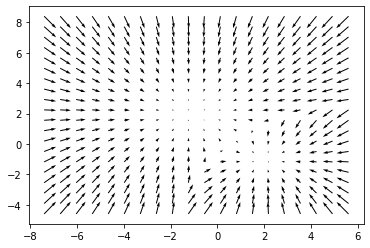

In [145]:
plt.figure()
plt.quiver(xgrid[0], xgrid[1], scoretestpts[:, 0], scoretestpts[:, 1])
plt.show()

In [146]:
xgrid = np.meshgrid(np.linspace(minbounds[0], maxbounds[0], 50), np.linspace(minbounds[1], maxbounds[1], 50))
testpts = torch.from_numpy(np.vstack([xgrid[0].flatten(), xgrid[1].flatten()]).T.astype(np.float32))

In [147]:
scoretestpts = np.stack([traindata.get_score(testpts[pi, :]) for pi in range(testpts.shape[0])])

In [148]:
scoretestpts = scoretestpts[...,0]

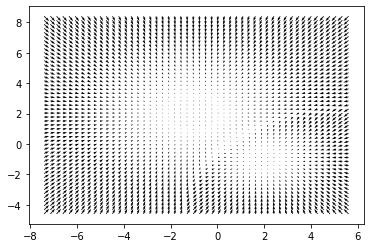

In [149]:
plt.figure()
plt.quiver(xgrid[0], xgrid[1], scoretestpts[:, 0], scoretestpts[:, 1])
plt.show()

In [152]:
scoregrid = scoretestpts[:, 0].reshape(50, 50), scoretestpts[:, 1].reshape(50, 50) #U, V

In [157]:
xgrid[0].shape

(50, 50)

In [164]:
lipsc_x1 = (scoregrid[0][:, 1:] - scoregrid[0][:, :-1])/(xgrid[0][:, 1:] - xgrid[0][:, :-1])

In [167]:
lipsc_x2 = (scoregrid[1][1:, :] - scoregrid[1][:-1, :])/(xgrid[1][1:, :] - xgrid[1][:-1, :])

In [174]:
lipsc_x2

array([[-1.5624979 , -1.5625015 , -1.5625015 , ..., -2.77777725,
        -2.77778444, -2.77777365],
       [-1.56250509, -1.5624979 , -1.56250509, ..., -2.77778084,
        -2.77778084, -2.77778444],
       [-1.56249431, -1.5625015 , -1.5624979 , ..., -2.77777725,
        -2.77777545, -2.77777725],
       ...,
       [-1.56251228, -1.56250509, -1.5625015 , ..., -1.56249431,
        -1.5625015 , -1.5625015 ],
       [-1.56249431, -1.5624979 , -1.5624979 , ..., -1.5625015 ,
        -1.5624979 , -1.5624979 ],
       [-1.5625015 , -1.5625015 , -1.56250509, ..., -1.5625015 ,
        -1.5625015 , -1.5624979 ]])

array([[-1.56249431, -1.5625015 , -1.5625015 , ..., -2.77777725,
        -2.77778444, -2.77777365],
       [-1.5624979 , -1.5625015 , -1.5625015 , ..., -2.77777545,
        -2.77778084, -2.77778444],
       [-1.56249431, -1.56250869, -1.56249431, ..., -2.77777725,
        -2.77778084, -2.77777725],
       ...,
       [-1.5625015 , -1.5625015 , -1.5625015 , ..., -1.5624979 ,
        -1.56250509, -1.5625015 ],
       [-1.5624979 , -1.5625015 , -1.5624979 , ..., -1.5624979 ,
        -1.5624979 , -1.56250509],
       [-1.5624979 , -1.5624979 , -1.56251228, ..., -1.56249431,
        -1.56250509, -1.5624979 ]])

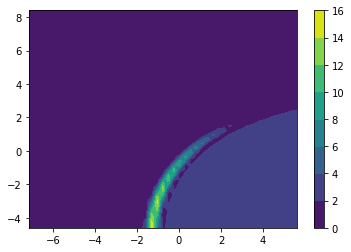

In [182]:
plt.figure()
c = plt.contourf(*[xg[:, 1:] for xg in xgrid], np.abs(lipsc_x1))
plt.colorbar(c)
plt.show()

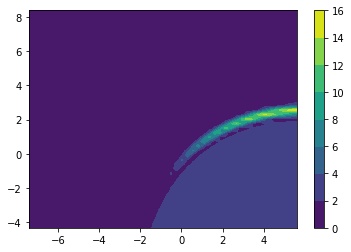

In [183]:
plt.figure()
c = plt.contourf(*[xg[1:, :] for xg in xgrid], np.abs(lipsc_x2))
plt.colorbar(c)
plt.show()

In [188]:
[i.covariance_matrix for i in traindata.dbns]

[tensor([[0.6400, 0.0000],
         [0.0000, 0.6400]]),
 tensor([[0.3600, 0.0000],
         [0.0000, 0.3600]])]